안녕하세요. 이번 글에서는 음성 신호에 대한 기본적인 내용을 설명하고 torchaudio를 사용하여 spectrogram과 melspectrogram feature를 만드는 과정에 대해 알아보겠습니다.

먼저 필요한 라이브러리를 가져오겠습니다.

In [1]:
!pip install torchaudio

import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms as AT
import matplotlib.pyplot as plt

다음으로는 음성 파일(.wav)를 torchaudio로 읽겠습니다. 음성 파일은 일정한 시간 간격을 가지고 어떤 지점의 음압을 측정한 것을 말합니다. 이때 일정한 시간 간격으로 음압을 측정하는 주파수를 sampling rate이라고 합니다. torchaudio를 사용해 음성을 읽으면 음성 데이터와 sampling rate을 반환하는데 아래의 음성에서는 sampling rate가 16000Hz 임을 알 수 있습니다. 한편, 음성 데이터의 크기를 보면 [1, 16000]으로 나와 있는데 1은 채널의 개수 즉, 녹음한 마이크의 개수를 의미하고 16000은 데이터의 길이를 의미합니다. sampling rate이 16000Hz 인데 길이가 16000이라는 것은 이 음성의 길이가 1초라는 것을 말합니다.

In [2]:
file_name = './DATA/test/test_00001.wav'
x, sr = torchaudio.load(file_name)
print(x.shape, sr)

torch.Size([1, 16000]) 16000


아래는 읽은 음성 데이터를 시각화 한 것입니다. 가로축은 시간을 세로축은 음압을 의미합니다. 음압이 큰 부분에 사람의 목소리가 있음을 추측할 수 있습니다. 

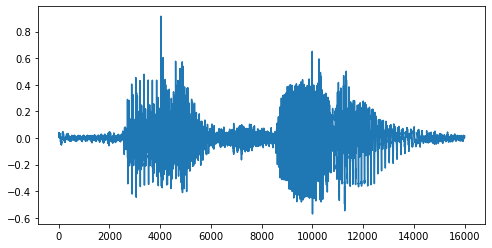

In [3]:
_, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(x[0, :])
plt.show()

다음으로는 이 음성 데이터를 딥러닝 모델이 더 잘 이해할 수 있는 spectrogram이나 melspectrogram으로 변환하는 방법에 대해 알아보겠습니다. 이에 관한 자세한 내용은 (https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html)에 잘 설명되어 있으니 자세한 내용을 알고 싶으신 분은 참고하시면 좋을 것 같습니다. 저는 간략하게 요약해서 설명하도록 하고 torchaudio를 활용하는 방법에 관해 설명하겠습니다.

1. 푸리에 변환 : 수학적으로 정확한 설명은 아니지만, 음성을 다루는 데에 도움이 되는 내용을 적겠습니다. 음성 신호에 푸리에 변환을 적용하면 각 진동수 성분이 그 음성에 얼마나 들어있는지 알 수 있습니다. 쉽게 설명하면 음성 신호에 저음이 얼마나 있고 고음이 얼마나 있는지를 정량적으로 구할 수 있습니다. 
2. STFT (Short time Fourier transform) : 대회의 데이터인 1초짜리 음성에 푸리에 변환을 적용하면 음성 전체에서 각 진동수 성분이 얼마나 들어있는지를 구할 수 있습니다. 다만, 음성 속의 단어를 파악하기 위해서는 시간에 따라 변하는 진동수 분포의 양상을 파악해야 합니다. 따라서, 음성을 작게(0.01초 수준) 잘라서 각 작은 조각에 푸리에 변환을 적용할 수 있습니다. 이것을 STFT 이라고 부르고 일반적으로 이 결과의 L2 norm을 spectrogram이라고 부릅니다. 
3. melspectrogram : melspectrogram은 spectrogram에 mel-filter라는 필터를 적용해서 얻어집니다. 이는 사람의 청각 기관이 고음에서 주파수의 변화에 덜 민감하고 저음에서 더 민감한 특징을 반영하고 있습니다. 딥러닝과 사람의 청각 반응은 관련이 없어 보일 수 있으나 음성 처리나 자연어 처리 분야에서도 melspectrogram은 널리 사용되고 있으며 좋은 성능을 보여줍니다. 또한, melspectrogram은 spectrogram보다 크기가 작아서 학습 속도 등에서 유리한 점이 있습니다.

torchaudio에서는 다음과 같이 spectrogram과 melspectrogram을 얻을 수 있는 프로세스를 정의할 수 있습니다. AmplitudeToDB는 power 단위의 spectrogram 또는 melspectrogram을 dB(로그) 단위로 변환해 줍니다. 개인적으로 dB 단위가 딥러닝 모델이 이해하기 편한 범위의 값을 제공한다고 생각합니다. 

1. n_fft : win_length의 크기로 잘린 음성의 작은 조각은 0으로 padding 되어서 n_fft로 크기가 맞춰집니다. 그렇게 padding 된 조각에 푸리에 변환이 적용됩니다. n_fft는 따라서 win_length 보다 크거나 같아야 하고 일반적으로 속도를 위해서 2^n의 값으로 설정합니다.
2. win_length : 이는 원래 음성을 작은 조각으로 자를 때 작은 조각의 크기를 의미합니다. 자연어 처리 분야에서는 25m의 크기를 기본으로 하고 있으며 16000Hz인 음성에서는 400에 해당하는 값입니다. 
3. hop_length : 이는 음성을 작은 조각으로 자를 때 자르는 간격을 의미합니다. 즉, 이 길이만큼 옆으로 밀면서 작은 조각을 얻습니다. 일반적으로 10ms의 크기를 기본으로 하고 있으며 16000Hz인 음성에서는 160에 해당하는 값입니다. 
4. n_mels : 적용할 mel filter의 개수를 의미합니다. 

In [4]:
spectrogram = nn.Sequential(
    AT.Spectrogram(n_fft=512, 
                   win_length=400, 
                   hop_length=160),
    AT.AmplitudeToDB()
)

mel_spectrogram = nn.Sequential(
    AT.MelSpectrogram(sample_rate=sr, 
                      n_fft=512, 
                      win_length=400,
                      hop_length=160,
                      n_mels=80),
    AT.AmplitudeToDB()
)

이제 실제 음성 데이터로부터 spectrogram과 melspectrogram을 얻어 보겠습니다. 각각의 크기는 채널을 무시하면 [257, 101], [80, 101]인데 101은 시간축 방향 성분 수, 257과 80은 주파수 방향 성분 수를 의미합니다. n_mel이 80이었으므로 melspectrogram의 주파수 방향 성분 수는 80인 것입니다. spectrogram의 경우 (n_fft / 2 + 1) 개의 주파수 방향 성분이 얻어지게 됩니다. 주파수 성분은 0Hz부터 sampling rate의 절반 즉, 8000Hz까지를 나타내게 됩니다. sampling rate의 절반까지 밖에 표현하지 못하는 이유는 Nyquist frequency에 대해 알아보시면 이해하실 수 있을 것입니다. 

In [5]:
spec = spectrogram(x)
mel = mel_spectrogram(x)
print(spec.shape, mel.shape)

torch.Size([1, 257, 101]) torch.Size([1, 80, 101])


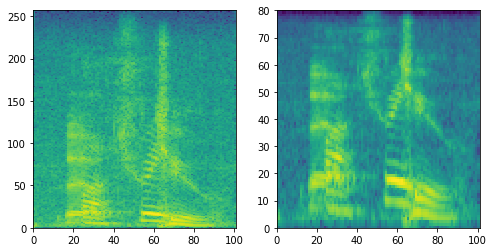

In [6]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].pcolor(spec[0])
ax[1].pcolor(mel[0])
plt.show()

마지막으로 spectrogram과 melspectrogram의 해상력에 대해 설명하겠습니다. win_length가 커질수록 주파수 성분에 대한 해상력은 높아지지만, 즉 더 정밀해지지만, 시간 성분에 대한 해상력은 낮아지게 됩니다. 즉, 더 정밀한 주파수 분포를 얻을 수 있으나 시간에 따른 주파수 변화를 관찰하기가 어려워집니다. 반대로 win_length가 작은 경우에는 주파수 성분에 대한 해상력은 낮아지지만, 시간 성분에 대한 해상력은 높아지게 됩니다. 따라서 적절한 값을 찾는 것이 중요합니다. 또한, n_fft를 키우는 경우 주파수 성분의 수는 증가할지 몰라도 실제 주파수의 해상력은 증가하지 않습니다.

긴 글 읽어주셔서 감사하고 글에서 오류가 있는 부분이 있거나 질문이 있으시면 댓글 남겨주시면 감사하겠습니다.